### Ethnicolr: NC Voter Registration Name Model

We build new LSTM models based on NC data. We start by assuming y = concatenation of ethnic code and race code. We remove U and also UN --- assuming they are 'missing at random.' This gives us 12 categories.


In [1]:
import keras
import tensorflow as tf
print(keras.__version__)
print(tf.__version__)

2.5.0
2.5.1


In [2]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix

In [3]:
NGRAMS = (2, 3)
SAMPLE = 1000000
EPOCHS = 15

# Florida voter
df = pd.read_csv('../dataverse_files/nc_voter_reg/nc_voter_name_gender_race_ethnic_age.csv', usecols=['last_name', 'first_name', 'race_code', 'ethnic_code'], nrows=SAMPLE * 2)
df.dropna(subset=['first_name', 'last_name'], inplace=True)

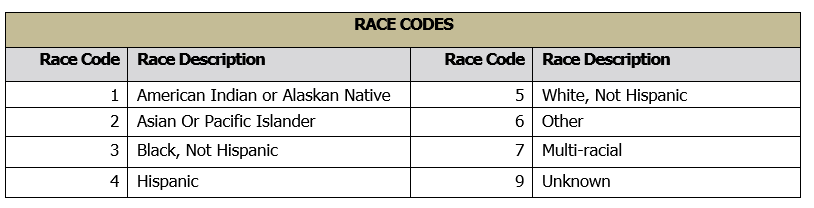

### Drop U and UN from race and ethnic.

In [4]:
df.drop(df[(df.race_code=='U')|(df.ethnic_code=='UN')].index, inplace=True)
df

,last_name,first_name,race_code,ethnic_code
0,AABEL,EVELYN,W,NL
2,AARON,CLAUDIA,W,NL
6,AARON,SANDRA,W,HL
7,AARON,WILLIE,W,NL
8,AARONSON,GENA,W,NL
...,...,...,...,...
1999993,LEAHY,YVETTE,W,NL
1999995,LEAK,ANTHONY,B,NL
1999996,LEAK,ANTOINETTE,B,NL
1999997,LEAK,BETTY,B,NL


In [5]:
df.groupby(['race_code', 'ethnic_code']).size()

race_code  ethnic_code
A          HL                 149
           NL               10142
B          HL                1497
           NL              266127
I          HL                 157
           NL                5284
M          HL                2634
           NL                5054
O          HL               18580
           NL               17627
W          HL               10598
           NL             1210076
dtype: int64

In [6]:
df['race'] = df['ethnic_code'] + '+' + df['race_code']
df

,last_name,first_name,race_code,ethnic_code,race
0,AABEL,EVELYN,W,NL,NL+W
2,AARON,CLAUDIA,W,NL,NL+W
6,AARON,SANDRA,W,HL,HL+W
7,AARON,WILLIE,W,NL,NL+W
8,AARONSON,GENA,W,NL,NL+W
...,...,...,...,...,...
1999993,LEAHY,YVETTE,W,NL,NL+W
1999995,LEAK,ANTHONY,B,NL,NL+B
1999996,LEAK,ANTOINETTE,B,NL,NL+B
1999997,LEAK,BETTY,B,NL,NL+B


In [7]:
df.drop_duplicates(inplace=True)

In [8]:
df.groupby(['race']).size()

race
HL+A       149
HL+B      1491
HL+I       156
HL+M      2606
HL+O     17325
HL+W     10281
NL+A      9682
NL+B    215904
NL+I      5048
NL+M      5016
NL+O     17326
NL+W    829509
dtype: int64

In [9]:
max_size = df['race'].value_counts().max()
lst = [df]
for class_index, group in df.groupby('race'):
    lst.append(group.sample(max_size-len(group), replace=True))
odf = pd.concat(lst)
odf

,last_name,first_name,race_code,ethnic_code,race
0,AABEL,EVELYN,W,NL,NL+W
2,AARON,CLAUDIA,W,NL,NL+W
6,AARON,SANDRA,W,HL,HL+W
7,AARON,WILLIE,W,NL,NL+W
8,AARONSON,GENA,W,NL,NL+W
...,...,...,...,...,...
400780,BATKIN,MARK,O,NL,NL+O
1360748,ROZO,HENRY,O,NL,NL+O
688306,BONILLA,CHRISTINE,O,NL,NL+O
1302621,BARNETT,CARRIE,O,NL,NL+O


In [10]:
odf.groupby('race').agg({'first_name': 'count'})

,first_name
race,
HL+A,829509
HL+B,829509
HL+I,829509
HL+M,829509
HL+O,829509
HL+W,829509
NL+A,829509
NL+B,829509
NL+I,829509


In [11]:
sdf = odf.sample(SAMPLE, random_state=21)
sdf

,last_name,first_name,race_code,ethnic_code,race
1735930,JACINTO,JOSE,O,HL,HL+O
1607570,VARGAS,EDWIN,W,HL,HL+W
1616995,WHITEHEAD,LINDA,I,NL,NL+I
718112,FLORES,ERIK,I,HL,HL+I
1743617,LANGLEY,VOTHI,O,NL,NL+O
...,...,...,...,...,...
433528,CRUZ,ANGELINA,M,HL,HL+M
1986758,JONES,KEITH,W,HL,HL+W
1487298,JAMES,DAYSHEA,B,HL,HL+B
126373,LACKEY,GRIER,W,NL,NL+W


In [12]:
# Additional features
sdf['first_name'] = sdf.first_name.str.title()
sdf['last_name'] = sdf.last_name.str.title()

rdf = sdf.groupby('race').agg({'first_name': 'count'})
rdf

,first_name
race,
HL+A,83345
HL+B,83134
HL+I,83668
HL+M,83366
HL+O,83054
HL+W,82852
NL+A,83706
NL+B,83335
NL+I,83141


In [13]:
rdf.to_csv('../models/nc_voter_reg/lstm/nc_name_race.csv', columns=[])

## Preprocessing the input data

In [14]:
%%time
# concat last name and first name
sdf['last_name_first_name'] = sdf['last_name'] + ' ' + sdf['first_name']

# build n-gram list
vect = CountVectorizer(analyzer='char', max_df=0.3, min_df=10, ngram_range=NGRAMS, lowercase=False) 
a = vect.fit_transform(sdf.last_name_first_name)
vocab = vect.vocabulary_

# sort n-gram by freq (highest -> lowest)
words = []
for b in vocab:
    c = vocab[b]
    #print(b, c, a[:, c].sum())
    words.append((a[:, c].sum(), b))
    #break
words = sorted(words, reverse=True)
words_list = [w[1] for w in words]
num_words = len(words_list)
print("num_words = %d" % num_words)

num_words = 11898
CPU times: user 18min 15s, sys: 1.73 s, total: 18min 17s
Wall time: 18min 18s


In [15]:
vocab

{'Ja': 2104,
 'ac': 4236,
 'ci': 5064,
 'in': 7083,
 'nt': 8648,
 'to': 10449,
 'o ': 8728,
 ' J': 147,
 'Jo': 2174,
 'os': 9100,
 'se': 10015,
 'Jac': 2108,
 'aci': 4245,
 'cin': 5076,
 'int': 7105,
 'nto': 8662,
 'to ': 10450,
 'o J': 8738,
 ' Jo': 156,
 'Jos': 2193,
 'ose': 9107,
 'Va': 3758,
 'ar': 4556,
 'rg': 9637,
 'ga': 6251,
 'as': 4586,
 's ': 9917,
 ' E': 65,
 'Ed': 1411,
 'dw': 5490,
 'wi': 11222,
 'Var': 3769,
 'arg': 4566,
 'rga': 9639,
 'gas': 6268,
 'as ': 4587,
 's E': 9922,
 ' Ed': 70,
 'Edw': 1424,
 'dwi': 5493,
 'win': 11233,
 'Wh': 3871,
 'hi': 6623,
 'it': 7204,
 'te': 10335,
 'eh': 5701,
 'he': 6582,
 'ea': 5568,
 'ad': 4258,
 'd ': 5207,
 ' L': 175,
 'Li': 2450,
 'nd': 8401,
 'da': 5248,
 'Whi': 3874,
 'hit': 6645,
 'ite': 7210,
 'teh': 10345,
 'ehe': 5707,
 'hea': 6585,
 'ead': 5573,
 'ad ': 4259,
 'd L': 5219,
 ' Li': 178,
 'Lin': 2463,
 'ind': 7089,
 'nda': 8404,
 'Fl': 1641,
 'lo': 7899,
 'or': 9072,
 're': 9597,
 'es': 5909,
 'Er': 1513,
 'ri': 9658,
 'ik':

In [16]:
from itertools import chain

def n_grams(seq, n=1):
    """Returns an itirator over the n-grams given a listTokens"""
    shiftToken = lambda i: (el for j,el in enumerate(seq) if j>=i)
    shiftedTokens = (shiftToken(i) for i in range(n))
    tupleNGrams = zip(*shiftedTokens)
    return tupleNGrams # if join in generator : (" ".join(i) for i in tupleNGrams)

def range_ngrams(listTokens, ngramRange=(1,2)):
    """Returns an itirator over all n-grams for n in range(ngramRange) given a listTokens."""
    ngrams = (ngramRange[0], ngramRange[1] + 1)
    return chain(*(n_grams(listTokens, i) for i in range(*ngramRange)))

In [17]:
%%time
def find_ngrams(text, ngrams):
    a = range_ngrams(text, ngrams)
    wi = []
    for i in a:
        w = ''.join(i)
        try:
            idx = words_list.index(w)
        except:
            idx = 0
        wi.append(idx)
    return wi

# build X from index of n-gram sequence
X = np.array(sdf.last_name_first_name.apply(lambda c: find_ngrams(c, NGRAMS)))

# check max/avg feature
X_len = []
for x in X:
    X_len.append(len(x))

max_feature_len = max(X_len)
avg_feature_len = int(np.mean(X_len))

print("Max feature len = %d, Avg. feature len = %d" % (max_feature_len, avg_feature_len))
y = np.array(sdf.race.astype('category').cat.codes)

# Split train and test dataset
X_train,  X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21, stratify=y)

Max feature len = 37, Avg. feature len = 12
CPU times: user 1min 6s, sys: 232 ms, total: 1min 6s
Wall time: 1min 6s


## Train a LSTM model

ref: http://machinelearningmastery.com/sequence-classification-lstm-recurrent-neural-networks-python-keras/

In [18]:
'''The dataset is actually too small for LSTM to be of any advantage
compared to simpler, much faster methods such as TF-IDF + LogReg.
Notes:

- RNNs are tricky. Choice of batch size is important,
choice of loss and optimizer is critical, etc.
Some configurations won't converge.

- LSTM loss decrease patterns during training can be quite different
from what you see with CNNs/MLPs/etc.
'''
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, Dropout, Activation
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.models import load_model

max_features = num_words # 20000
feature_len = 25 # avg_feature_len # cut texts after this number of words (among top max_features most common words)
batch_size = 32

print(len(X_train), 'train sequences')
print(len(X_test), 'test sequences')

print('Pad sequences (samples x time)')
X_train = sequence.pad_sequences(X_train, maxlen=feature_len)
X_test = sequence.pad_sequences(X_test, maxlen=feature_len)
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)

num_classes = np.max(y_train) + 1
print(num_classes, 'classes')

print('Convert class vector to binary class matrix '
      '(for use with categorical_crossentropy)')
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

800000 train sequences
200000 test sequences
Pad sequences (samples x time)
X_train shape: (800000, 25)
X_test shape: (200000, 25)
12 classes
Convert class vector to binary class matrix (for use with categorical_crossentropy)
y_train shape: (800000, 12)
y_test shape: (200000, 12)


In [19]:
print('Build model...')

if True:
    model = Sequential()
    model.add(Embedding(num_words, 32, input_length=feature_len))
    model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(num_classes, activation='softmax'))
if False:
    embedding_vecor_length = 50
    model = Sequential()
    model.add(Embedding(num_words, embedding_vecor_length, input_length=feature_len))
    model.add(Conv1D(activation="relu", padding="same", filters=32, kernel_size=3))
    model.add(MaxPooling1D(pool_size=2))
    model.add(LSTM(100))
    model.add(Dense(num_classes, activation='softmax'))

# try using different optimizers and different optimizer configs
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print(model.summary())

Build model...
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 25, 32)            380736    
_________________________________________________________________
lstm (LSTM)                  (None, 128)               82432     
_________________________________________________________________
dense (Dense)                (None, 12)                1548      
Total params: 464,716
Trainable params: 464,716
Non-trainable params: 0
_________________________________________________________________
None


In [20]:
%%time
print('Train...')
model.fit(X_train, y_train, batch_size=batch_size, epochs=EPOCHS,
          validation_split=0.1, verbose=1)
score, acc = model.evaluate(X_test, y_test,
                            batch_size=batch_size, verbose=1)
print('Test score:', score)
print('Test accuracy:', acc)

Train...
Epoch 1/15
22500/22500 [==============================] - 550s 23ms/step - loss: 1.8260 - accuracy: 0.3389 - val_loss: 1.4445 - val_accuracy: 0.4673
Epoch 2/15
22500/22500 [==============================] - 524s 23ms/step - loss: 1.4399 - accuracy: 0.4721 - val_loss: 1.2637 - val_accuracy: 0.5355
Epoch 3/15
22500/22500 [==============================] - 530s 24ms/step - loss: 1.3269 - accuracy: 0.5135 - val_loss: 1.1829 - val_accuracy: 0.5634
Epoch 4/15
22500/22500 [==============================] - 526s 23ms/step - loss: 1.2762 - accuracy: 0.5315 - val_loss: 1.1368 - val_accuracy: 0.5821
Epoch 5/15
22500/22500 [==============================] - 525s 23ms/step - loss: 1.2442 - accuracy: 0.5432 - val_loss: 1.1030 - val_accuracy: 0.5914
Epoch 6/15
22500/22500 [==============================] - 528s 23ms/step - loss: 1.2219 - accuracy: 0.5524 - val_loss: 1.0776 - val_accuracy: 0.6029
Epoch 7/15
22500/22500 [==============================] - 525s 23ms/step - loss: 1.2086 - accurac

In [21]:
print('Test score:', score)
print('Test accuracy:', acc)

Test score: 0.9838615655899048
Test accuracy: 0.6368200182914734


## Confusion Matrix

In [22]:
p = model.predict(X_test, verbose=2) # to predict probability
y_pred = np.argmax(p, axis=-1)
target_names = list(sdf.race.astype('category').cat.categories)
print(classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target_names))

conf_mat = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
print(conf_mat)

6250/6250 - 27s
              precision    recall  f1-score   support

        HL+A       0.98      1.00      0.99     16669
        HL+B       0.86      1.00      0.92     16627
        HL+I       0.98      1.00      0.99     16734
        HL+M       0.74      0.97      0.84     16673
        HL+O       0.47      0.55      0.51     16611
        HL+W       0.42      0.23      0.29     16570
        NL+A       0.67      0.72      0.69     16741
        NL+B       0.40      0.33      0.36     16667
        NL+I       0.58      0.72      0.65     16628
        NL+M       0.50      0.64      0.56     16738
        NL+O       0.39      0.08      0.13     16632
        NL+W       0.34      0.39      0.37     16710

    accuracy                           0.64    200000
   macro avg       0.61      0.64      0.61    200000
weighted avg       0.61      0.64      0.61    200000

[[16669     0     0     0     0     0     0     0     0     0     0     0]
 [    0 16621     0     6     0     0     

In [23]:
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

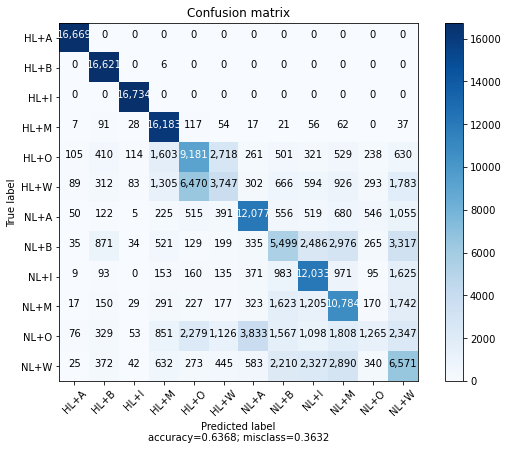

In [24]:
plot_confusion_matrix(conf_mat, target_names, normalize=False)

### Save model

In [25]:
model.save('../models/nc_voter_reg/lstm/nc_voter_name_lstm_oversample.h5')

In [26]:
words_df = pd.DataFrame(words_list, columns=['vocab'])
words_df.to_csv('../models/nc_voter_reg/lstm/nc_voter_name_vocab_oversample.csv', index=False, encoding='utf-8')